In [186]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model
from kneed import KneeLocator
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from keras.models import Sequential
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import Ridge
from keras.layers import Conv1D, Flatten, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## RFE

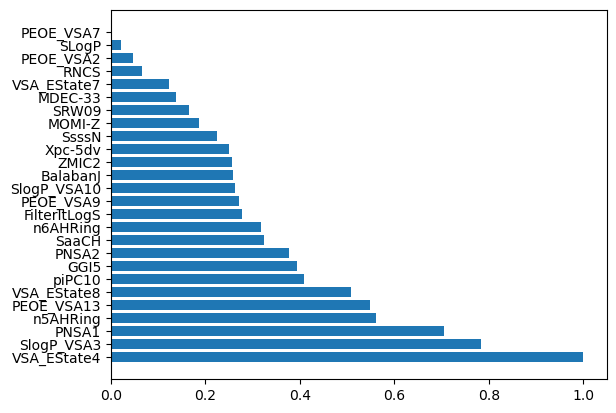

In [119]:
with open('./data/importances_rfe_scaled.pickle', 'rb') as handle:
    importances_rfe = pickle.load(handle)
plt.barh(list(importances_rfe.keys()), list(importances_rfe.values()))
plt.show()

## ARD

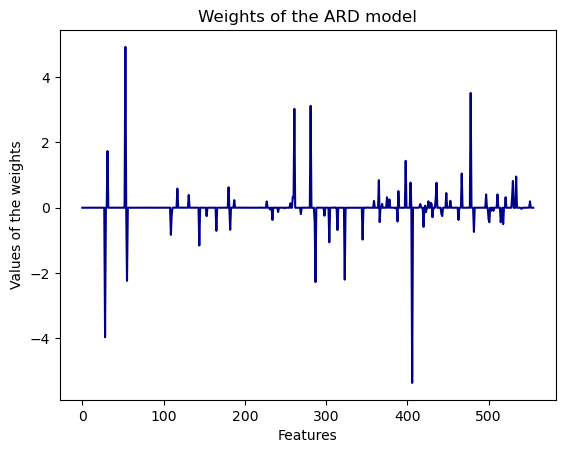

In [120]:
train = pd.read_pickle("./data/train.pkl")
test = pd.read_pickle("./data/test.pkl")
whole_df = pd.concat([train, test], ignore_index=True)


ard = linear_model.ARDRegression()
ard.fit(whole_df.drop(columns=['pIC50', 'ChEMBL_ID', 'smiles']).to_numpy(), whole_df['pIC50'])

plt.title("Weights of the ARD model")
plt.plot(ard.coef_, color="darkblue")
plt.xlabel("Features")
plt.ylabel("Values of the weights")
plt.show()

Knee at: 30	 Treshold:  0.44912665729838025


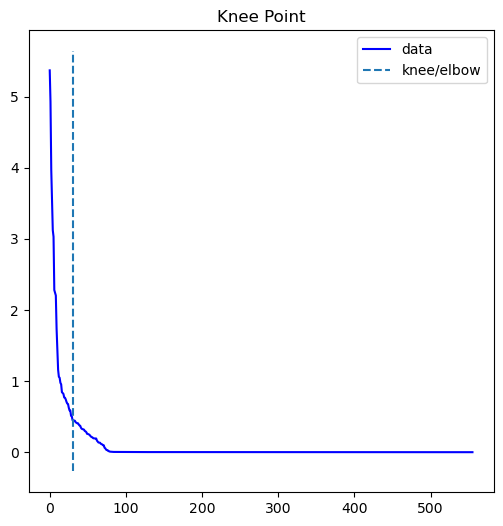

In [122]:
kneedle = KneeLocator(list(range(len(ard.coef_))), sorted(np.abs(ard.coef_), reverse=True), S=1, curve='convex', direction='decreasing')
print(f'Knee at: {kneedle.knee}\t Treshold: ',kneedle.knee_y)
kneedle.plot_knee()

30


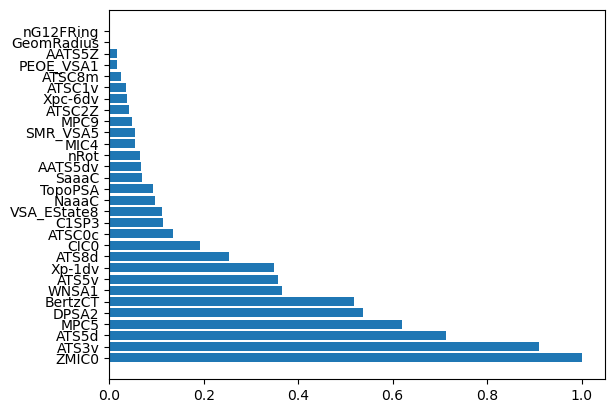

{'ZMIC0': 1.0,
 'ATS3v': 0.9091641381249167,
 'ATS5d': 0.7125860907527457,
 'MPC5': 0.6191573804243402,
 'DPSA2': 0.5381362771854652,
 'BertzCT': 0.5191999274757312,
 'WNSA1': 0.3651197116153109,
 'ATS5v': 0.3571871510343912,
 'Xp-1dv': 0.3494243650539716,
 'ATS8d': 0.25318549403913393,
 'CIC0': 0.19193028709498983,
 'ATSC0c': 0.13457579353321242,
 'C1SP3': 0.11440811134779266,
 'VSA_EState8': 0.11167816173706592,
 'NaaaC': 0.09720101223291946,
 'TopoPSA': 0.09279329894055709,
 'SaaaC': 0.06980346524482277,
 'AATS5dv': 0.06769418127439891,
 'nRot': 0.06488541762350952,
 'MIC4': 0.05472362098062827,
 'SMR_VSA5': 0.0539460267380431,
 'MPC9': 0.04917569911688515,
 'ATSC2Z': 0.042210494813269335,
 'Xpc-6dv': 0.037091690345585626,
 'ATSC1v': 0.03591098042718618,
 'ATSC8m': 0.025139137050125496,
 'PEOE_VSA1': 0.017356762706580375,
 'AATS5Z': 0.017072045186544475,
 'GeomRadius': 0.001652787558028317,
 'nG12FRing': 0.0}

In [124]:
mask = abs(ard.coef_) > kneedle.knee_y

cols = np.array(whole_df.loc[:,~train.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])].columns)[mask]
vals = np.abs(ard.coef_[mask])
vals = (vals - min(vals)) / (max(vals) -  min(vals))
feature_weights = dict(zip(cols, vals))
importances_ard = dict(sorted(feature_weights.items(), key=lambda x:abs(x[1]), reverse=True))

print(len(feature_weights))
plt.barh(list(importances_ard.keys()), list(importances_ard.values()))
plt.show()
importances_ard

### Random Forest

Knee at: 30	 Treshold:  0.05070432004973622


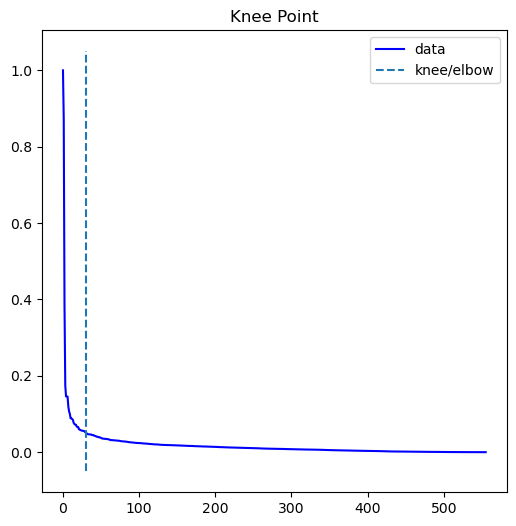

In [126]:
forest = RandomForestRegressor(random_state=0)
forest.fit(whole_df.drop(columns=['pIC50', 'ChEMBL_ID', 'smiles']).to_numpy(), whole_df['pIC50'])

scaled_importances_forest = (forest.feature_importances_ - min(forest.feature_importances_)) / (max(forest.feature_importances_) - min(forest.feature_importances_))

kneedle = KneeLocator(list(range(len(scaled_importances_forest))), sorted(np.abs(scaled_importances_forest), reverse=True), S=10, curve='convex', direction='decreasing')
print(f'Knee at: {kneedle.knee}\t Treshold: ',kneedle.knee_y)
kneedle.plot_knee()


30


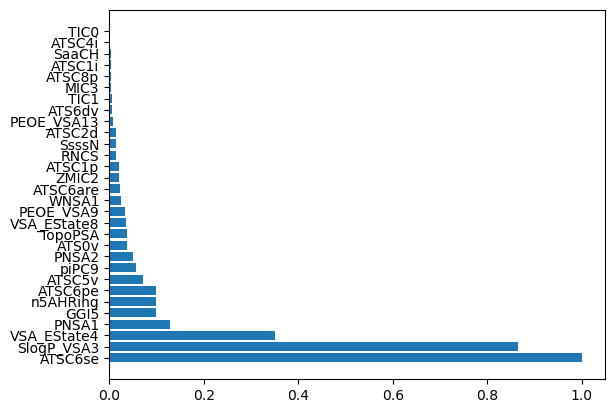

{'ATSC6se': 1.0,
 'SlogP_VSA3': 0.8654021633256065,
 'VSA_EState4': 0.35147615076522143,
 'PNSA1': 0.12872064244363884,
 'GGI5': 0.09819450090837621,
 'n5AHRing': 0.09792106990764729,
 'ATSC6pe': 0.09787983886837283,
 'ATSC5v': 0.07067580484474323,
 'piPC9': 0.05671769039046374,
 'PNSA2': 0.05027833229264053,
 'ATS0v': 0.037832443056895065,
 'TopoPSA': 0.03755328210532721,
 'VSA_EState8': 0.035486418255004315,
 'PEOE_VSA9': 0.0337152842739965,
 'WNSA1': 0.025232756980214825,
 'ATSC6are': 0.022018808119336798,
 'ZMIC2': 0.02028677462276017,
 'ATSC1p': 0.019915015485874626,
 'RNCS': 0.015055330562280658,
 'SsssN': 0.013580628466980384,
 'ATSC2d': 0.013514767878004581,
 'PEOE_VSA13': 0.007175351277061842,
 'ATS6dv': 0.006434666216103073,
 'TIC1': 0.005102371138747058,
 'MIC3': 0.0042136344319780705,
 'ATSC8p': 0.0033973128789561934,
 'ATSC1i': 0.0030881052347895635,
 'SaaCH': 0.0029364848441789646,
 'ATSC4i': 0.0021253074529658197,
 'TIC0': 0.0}

In [127]:
mask = abs(scaled_importances_forest) > kneedle.knee_y

cols = np.array(whole_df.loc[:,~train.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])].columns)[mask]
vals = np.abs(scaled_importances_forest[mask])
vals = (vals - min(vals)) / (max(vals) -  min(vals))
feature_weights = dict(zip(cols, vals))
importances_forest = dict(sorted(feature_weights.items(), key=lambda x:abs(x[1]), reverse=True))

print(len(feature_weights))
plt.barh(list(importances_forest.keys()), list(importances_forest.values()))
plt.show()
importances_forest

### Usporedba izdvojenih značajki

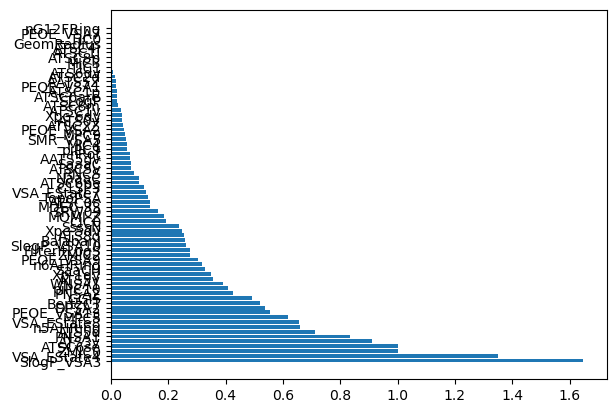

70


In [129]:
all_keys = set(importances_ard.keys()).union(importances_forest.keys()).union(importances_rfe)
importances_combined = {key: importances_ard.get(key, 0) + 
                        importances_forest.get(key, 0) + importances_rfe.get(key, 0) for key in all_keys}
importances_combined = dict(sorted(importances_combined.items(), key=lambda x:abs(x[1]), reverse=True))

plt.barh(list(importances_combined.keys()), list(importances_combined.values()))
plt.show()
print(len(importances_combined))

Knee at: 32	 Treshold:  0.13662445404827409


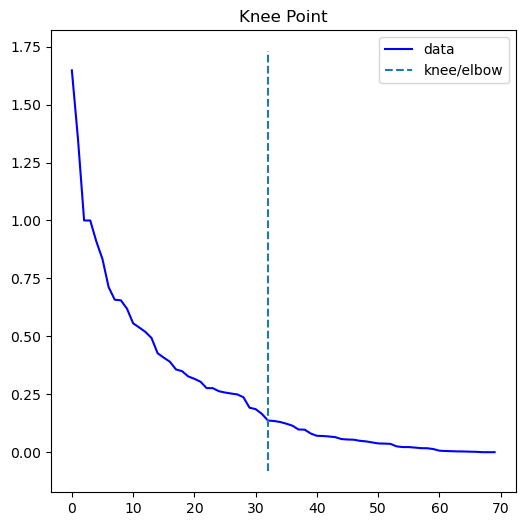

In [131]:
kneedle = KneeLocator(list(range(len(importances_combined))), sorted(list(importances_combined.values()), reverse=True), S=5, curve='convex', direction='decreasing')
print(f'Knee at: {kneedle.knee}\t Treshold: ',kneedle.knee_y)
kneedle.plot_knee()

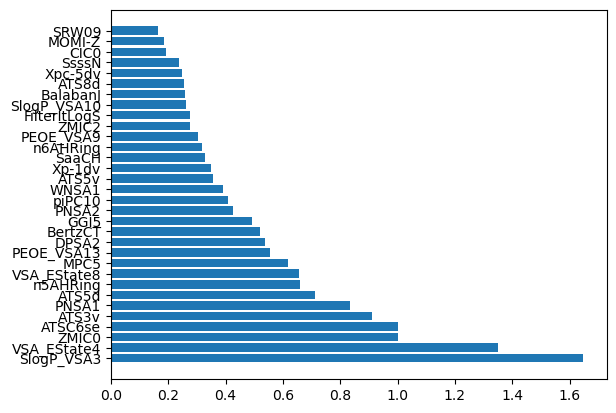

In [132]:
mask = list(importances_combined.values()) > kneedle.knee_y
selected_cols = np.array(list(importances_combined.keys()))[mask]
plt.barh(selected_cols, np.array(list(importances_combined.values()))[mask])
plt.show()

In [133]:
selected_cols

array(['SlogP_VSA3', 'VSA_EState4', 'ZMIC0', 'ATSC6se', 'ATS3v', 'PNSA1',
       'ATS5d', 'n5AHRing', 'VSA_EState8', 'MPC5', 'PEOE_VSA13', 'DPSA2',
       'BertzCT', 'GGI5', 'PNSA2', 'piPC10', 'WNSA1', 'ATS5v', 'Xp-1dv',
       'SaaCH', 'n6AHRing', 'PEOE_VSA9', 'ZMIC2', 'FilterItLogS',
       'SlogP_VSA10', 'BalabanJ', 'ATS8d', 'Xpc-5dv', 'SsssN', 'CIC0',
       'MOMI-Z', 'SRW09'], dtype='<U12')

### Odabir značajki

In [143]:
def selectColumns(df, columns_to_select):
    df_temp = df[columns_to_select]
    df_temp['pIC50'] = df['pIC50']
    return df_temp.copy()


train = pd.read_pickle("./data/train.pkl")
train = selectColumns(train, selected_cols)
test = pd.read_pickle("./data/test.pkl")
test = selectColumns(test, selected_cols)

train_DL = pd.read_pickle("./data/train_DL.pkl")
train_DL = selectColumns(train_DL, selected_cols)
test_DL = pd.read_pickle("./data/test_DL.pkl")
test_DL = selectColumns(test_DL, selected_cols)
val_DL = pd.read_pickle("./data/validate_DL.pkl")
val_DL = selectColumns(val_DL, selected_cols)


C:\Users\afs\AppData\Local\Temp\ipykernel_26212\2185170354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pIC50'] = df['pIC50']
C:\Users\afs\AppData\Local\Temp\ipykernel_26212\2185170354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['pIC50'] = df['pIC50']
C:\Users\afs\AppData\Local\Temp\ipykernel_26212\2185170354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Funkcije za učitavanje i evaluaciju

In [144]:
def load_data(train, test):
    train_X = np.array(train.loc[:,~train.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    train_Y = np.array(train.pIC50)
    test_X = np.array(test.loc[:,~test.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    test_Y = np.array(test.pIC50)

    return train_X, train_Y, test_X, test_Y

def load_data_DL(train_DL, test_DL, val_DL):
    train_X = np.array(train_DL.loc[:,~train_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    train_Y = np.array(train_DL.pIC50)
    test_X = np.array(test_DL.loc[:,~test_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    test_Y = np.array(test_DL.pIC50)
    val_X = np.array(val_DL.loc[:,~val_DL.columns.isin(['ChEMBL_ID', 'smiles','pIC50'])])
    val_Y = np.array(val_DL.pIC50)

    return train_X, train_Y, test_X, test_Y, val_X, val_Y

def root_mean_squared_error(test_y, pred_y):
    return np.sqrt(mean_squared_error(test_y, pred_y))

def evaluate(train_Y, pred_Y_train, test_Y, pred_Y_test):
    print("Train Root Mean Squared Error:", root_mean_squared_error(train_Y, pred_Y_train))
    print("Train Mean Absolute Error:", mean_absolute_error(train_Y, pred_Y_train))
    print("Train R2:", r2_score(train_Y, pred_Y_train))
    print('\n')
    print("Test Root Mean Squared Error:", mean_squared_error(test_Y, pred_Y_test))
    print("Test Mean Absolute Error:", mean_absolute_error(test_Y, pred_Y_test))
    print("Test R2:", r2_score(test_Y, pred_Y_test))
    print('\n')

def visualizeTrainTest(train_Y, pred_Y_train, test_Y, pred_Y_test):
    fig, axs = plt.subplots(1,2)
    fig.set_figheight(5)
    fig.set_figwidth(10)

    pred_pairs_train = {key: value for key, value in zip(train_Y, pred_Y_train)}
    # pred_pairs_train = dict(sorted(pred_pairs_train.items()))
    pred_pairs_test = {key: value for key, value in zip(test_Y, pred_Y_test)}
    # pred_pairs_test = dict(sorted(pred_pairs_test.items()))


    axs[0].set_title("Train predictions")
    axs[0].plot(pred_pairs_train.values(), color="darkblue", label='predictions')
    axs[0].plot(pred_pairs_train.keys(), '.', color="red", label='true data', markersize=5)
    axs[0].set_xlabel("Molecules")
    axs[0].set_ylabel("pIC50")
    axs[0].legend()
    axs[0].grid()

    axs[1].set_title("Test predictions")
    axs[1].plot(pred_pairs_test.values(), color="darkblue", label='predictions')
    axs[1].plot(pred_pairs_test.keys(), '.', color="red", label='true data', markersize=5)
    axs[1].set_xlabel("Molecules")
    axs[1].set_ylabel("pIC50")
    axs[1].legend()
    axs[1].grid()

    fig.tight_layout()
    plt.show()

### Linearna regresija

Train Root Mean Squared Error: 0.15432046683818948
Train Mean Absolute Error: 0.11980727305488396
Train R2: 0.45541922346564745


Test Root Mean Squared Error: 0.03771047881735724
Test Mean Absolute Error: 0.15402767247221918
Test R2: 0.23711036987716472




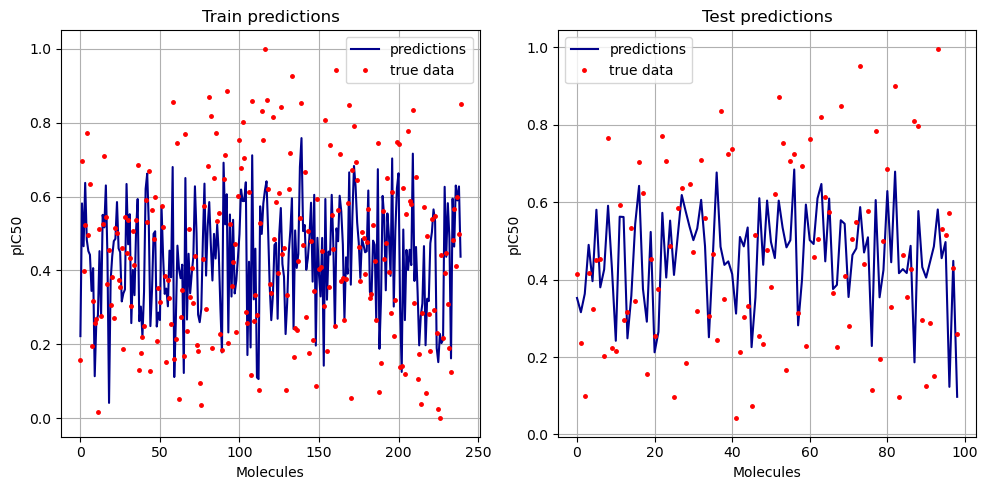

In [148]:
train_X, train_Y, test_X, test_Y = load_data(train, test)

lr = LinearRegression()
lr.fit(train_X, train_Y)

pred_Y_train_lr = lr.predict(train_X)
pred_Y_test_lr = lr.predict(test_X)
evaluate(train_Y, pred_Y_train_lr, test_Y, pred_Y_test_lr)
visualizeTrainTest(train_Y, pred_Y_train_lr, test_Y, pred_Y_test_lr)

### SVM

Train Root Mean Squared Error: 0.12044269644190003
Train Mean Absolute Error: 0.09832952673171007
Train R2: 0.668276537651527


Test Root Mean Squared Error: 0.030175988593619675
Test Mean Absolute Error: 0.136821447864896
Test R2: 0.3895344344930086




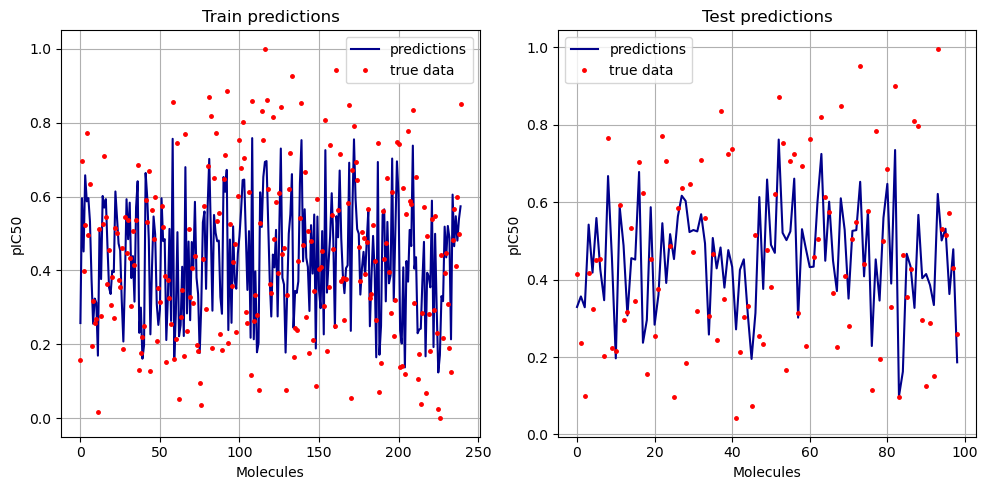

In [150]:
train_X, train_Y, test_X, test_Y = load_data(train, test)

svm = SVR()
svm.fit(train_X, train_Y)

pred_Y_train_svm = svm.predict(train_X)
pred_Y_test_svm = svm.predict(test_X)
evaluate(train_Y, pred_Y_train_svm, test_Y, pred_Y_test_svm)
visualizeTrainTest(train_Y, pred_Y_train_svm, test_Y, pred_Y_test_svm)

### Ridge regression

In [170]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_data_DL(train_DL, test_DL, val_DL)

for alpha in [0.1, 0.5, 1, 2, 4, 6]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(train_X, train_Y)

    pred_Y_train_ridge = ridge.predict(train_X)
    pred_Y_val_ridge = ridge.predict(val_X)

    print('=================================================================')
    print(f'Alpha: {alpha}')
    evaluate(train_Y, pred_Y_train_ridge, test_Y, pred_Y_val_ridge)



Alpha: 0.1
Train Root Mean Squared Error: 0.15880705795122194
Train Mean Absolute Error: 0.12438870096804448
Train R2: 0.4328789987575281


Test Root Mean Squared Error: 0.07700593641094541
Test Mean Absolute Error: 0.22881789489555027
Test R2: -0.5302743060552702


Alpha: 0.5
Train Root Mean Squared Error: 0.16238534642912697
Train Mean Absolute Error: 0.1282963637555147
Train R2: 0.4070339862713278


Test Root Mean Squared Error: 0.07280182656933773
Test Mean Absolute Error: 0.22147372652788455
Test R2: -0.4467295617109641


Alpha: 1
Train Root Mean Squared Error: 0.16465062479102627
Train Mean Absolute Error: 0.13062697731664064
Train R2: 0.39037482123932876


Test Root Mean Squared Error: 0.07087884186490385
Test Mean Absolute Error: 0.21745870563562195
Test R2: -0.40851570156869355


Alpha: 2
Train Root Mean Squared Error: 0.16751472315617844
Train Mean Absolute Error: 0.13329987175488983
Train R2: 0.3689814915835111


Test Root Mean Squared Error: 0.06879438691369748
Test Mean Ab

Train Root Mean Squared Error: 0.16238534642912697
Train Mean Absolute Error: 0.1282963637555147
Train R2: 0.4070339862713278


Test Root Mean Squared Error: 0.03519429909946053
Test Mean Absolute Error: 0.1513333272700715
Test R2: 0.3006132495536603




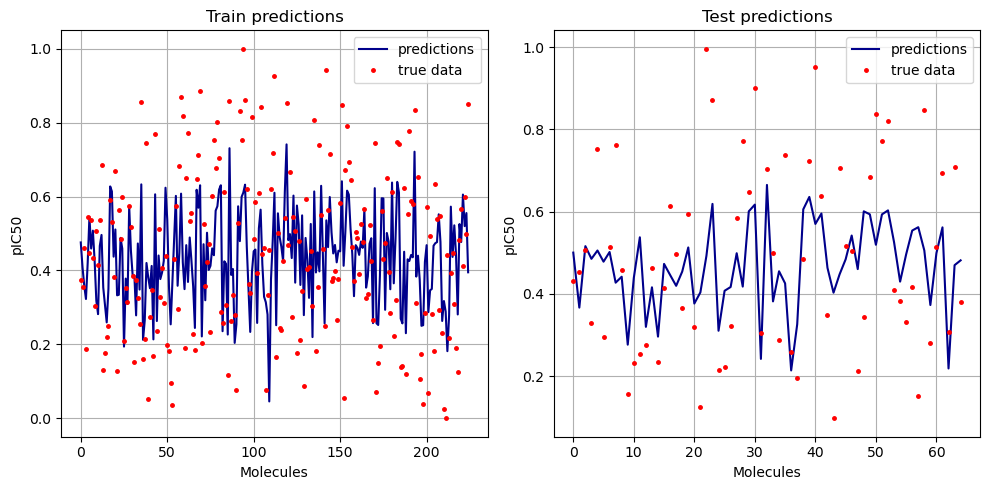

In [171]:
ridge = Ridge(alpha=0.5)
ridge.fit(train_X, train_Y)

pred_Y_train_ridge = ridge.predict(train_X)
pred_Y_test_ridge = ridge.predict(test_X)

evaluate(train_Y, pred_Y_train_ridge, test_Y, pred_Y_test_ridge)
visualizeTrainTest(train_Y, pred_Y_train_ridge, test_Y, pred_Y_test_ridge)

### XGboost

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
Best Hyperparameters: {'colsample_bytree': 0.3, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'reg_lambda': 1, 'subsample': 0.9}
Train Root Mean Squared Error: 0.045735114035320705
Train Mean Absolute Error: 0.035288888232775366
Train R2: 0.952963428069705


Test Root Mean Squared Error: 0.02683475461338783
Test Mean Absolute Error: 0.1308205573681834
Test R2: 0.46673545692603624




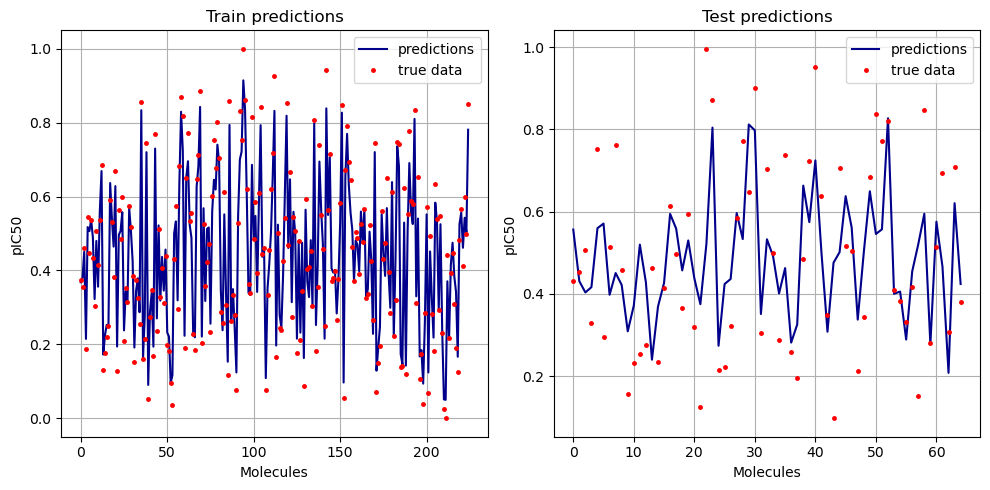

In [167]:
train_X, train_Y, test_X, test_Y = load_data(train_DL, test_DL)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 10],
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.3, 0.65, 1.0],
    'subsample': [0.8, 0.9, 1.0],
    'reg_lambda': [1, 5]
}

xg_reg = xgb.XGBRegressor(objective='reg:squarederror')

grid_search = GridSearchCV(
    estimator=xg_reg,
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_X, train_Y)

print("Best Hyperparameters:", grid_search.best_params_)

best_xg_reg = grid_search.best_estimator_

pred_Y_train_xgb = best_xg_reg.predict(train_X)
pred_Y_test_xgb = best_xg_reg.predict(test_X)

evaluate(train_Y, pred_Y_train_xgb, test_Y, pred_Y_test_xgb)
visualizeTrainTest(train_Y, pred_Y_train_xgb, test_Y, pred_Y_test_xgb)

### DNN

In [180]:
from keras.models import Sequential
from keras.layers import Dense

train_X, train_Y, test_X, test_Y = load_data(train, test)

## Building the model

DNN = Sequential()
DNN.add(Dense(32, kernel_initializer='normal', input_dim = train_X.shape[1], activation='relu'))
DNN.add(Dense(64, kernel_initializer='normal',activation='relu'))
DNN.add(Dense(64, kernel_initializer='normal',activation='relu'))
DNN.add(Dense(1, kernel_initializer='normal',activation='linear'))

## Compiling

DNN.compile(loss='mse', optimizer='adam', metrics=['mse'])
DNN.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dense_13 (Dense)            (None, 64)                2112      
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 7393 (28.88 KB)
Trainable params: 7393 (28.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [181]:
from sklearn.model_selection import  KFold
avg_train_loss = []
avg_val_loss = []


N_EPOCHS = 100

for n_epoch in range(N_EPOCHS):
    print('\nEPOCH ', n_epoch+1, '-----------------------------------------------------------------------')
    folds = list(KFold(n_splits=3, shuffle=True, random_state=0).split(train_X, train_Y))
    train_loss = []; train_acc = []
    val_loss = []; val_acc = []

    for j, (train_idx, val_idx) in enumerate(folds):
        print('\nEpoch ', n_epoch, 'Fold ',j)
        X_train_cv = train_X[train_idx]
        y_train_cv = train_Y[train_idx]
        X_valid_cv = train_X[val_idx]
        y_valid_cv = train_Y[val_idx]

        DNN.fit(X_train_cv, y_train_cv, batch_size=32, epochs=1, validation_data=(X_valid_cv, y_valid_cv))
        train_loss.append(DNN.history.history['loss'])
        val_loss.append(DNN.history.history['val_loss'])
    
    avg_train_loss.append(np.average(train_loss))
    avg_val_loss.append(np.average(val_loss))
    print(f'Epoch {n_epoch} - val_loss: {avg_val_loss[-1]}\n')


EPOCH  1 -----------------------------------------------------------------------

Epoch  0 Fold  0
8/8 [==============================] - 1s 20ms/step - loss: 0.2071 - mse: 0.2071 - val_loss: 0.2215 - val_mse: 0.2215

Epoch  0 Fold  1
8/8 [==============================] - 0s 10ms/step - loss: 0.1887 - mse: 0.1887 - val_loss: 0.1522 - val_mse: 0.1522

Epoch  0 Fold  2
8/8 [==============================] - 0s 10ms/step - loss: 0.1297 - mse: 0.1297 - val_loss: 0.0682 - val_mse: 0.0682
Epoch 0 - val_loss: 0.14729763815800348


EPOCH  2 -----------------------------------------------------------------------

Epoch  1 Fold  0
8/8 [==============================] - 0s 9ms/step - loss: 0.0556 - mse: 0.0556 - val_loss: 0.0614 - val_mse: 0.0614

Epoch  1 Fold  1
8/8 [==============================] - 0s 9ms/step - loss: 0.0573 - mse: 0.0573 - val_loss: 0.0454 - val_mse: 0.0454

Epoch  1 Fold  2
8/8 [==============================] - 0s 9ms/step - loss: 0.0504 - mse: 0.0504 - val_loss: 0.0458 

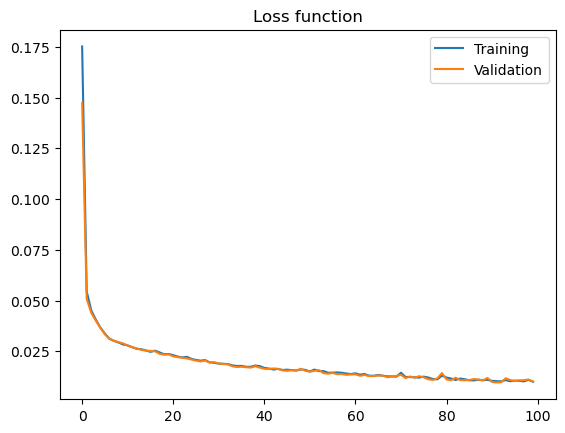

In [182]:
plt.plot(avg_train_loss, label='Training')
plt.plot(avg_val_loss, label='Validation')
plt.title('Loss function')
plt.legend()
plt.show()

4/4 [==============================] - 0s 1ms/step
Train Root Mean Squared Error: 0.10001287139838548
Train Mean Absolute Error: 0.07767264135758621
Train R2: 0.771267939456636


Test Root Mean Squared Error: 0.02964995485629219
Test Mean Absolute Error: 0.13925698392197072
Test R2: 0.40017618967319446




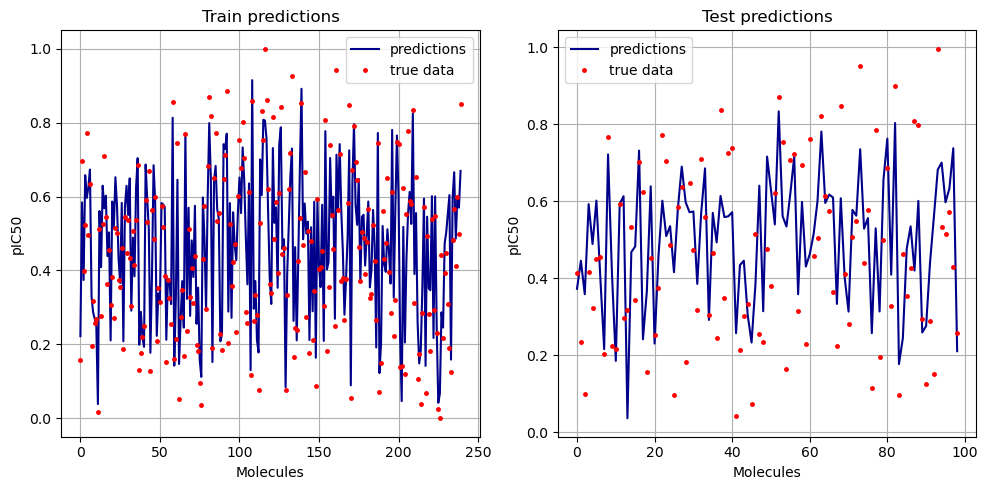

In [183]:
pred_Y_train_dnn = DNN.predict(train_X)
pred_Y_test_dnn = DNN.predict(test_X)
evaluate(train_Y, pred_Y_train_dnn, test_Y, pred_Y_test_dnn)
visualizeTrainTest(train_Y, pred_Y_train_dnn, test_Y, pred_Y_test_dnn)

### CNN

In [184]:
train_X, train_Y, test_X, test_Y, val_X, val_Y = load_data_DL(train_DL, test_DL, val_DL)

X_train = (train_X.astype('float32'))
X_val = val_X.astype('float32')
X_test = test_X.astype('float32')

train_X.shape, val_X.shape, test_X.shape

((335, 32), (72, 32), (72, 32))

In [195]:
model_CNN = Sequential()
model_CNN.add(Dense(8, activation='relu', input_shape=(X_train.shape[1], 1)))
model_CNN.add(Conv1D(4, 5, activation='relu'))
model_CNN.add(Conv1D(8, 3, activation='relu'))
model_CNN.add(Flatten())
model_CNN.add(Dense(8, activation='relu'))
model_CNN.add(Dense(1))

model_CNN.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mse'],)


print(model_CNN.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32, 8)             16        
                                                                 
 conv1d_6 (Conv1D)           (None, 28, 4)             164       
                                                                 
 conv1d_7 (Conv1D)           (None, 26, 8)             104       
                                                                 
 flatten_3 (Flatten)         (None, 208)               0         
                                                                 
 dense_26 (Dense)            (None, 8)                 1672      
                                                                 
 dense_27 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1965 (7.68 KB)
Trainable params: 1965 (7

In [196]:
X_train = X_train.reshape(train_X.shape[0], train_X.shape[1], 1)
X_test = X_test.reshape(test_X.shape[0], test_X.shape[1], 1)

from sklearn.model_selection import  KFold
avg_train_loss = []
avg_val_loss = []


N_EPOCHS = 200

for n_epoch in range(N_EPOCHS):
    print('\nEPOCH ', n_epoch+1, '-----------------------------------------------------------------------')
    folds = list(KFold(n_splits=3, shuffle=True, random_state=0).split(train_X, train_Y))
    train_loss = []; train_acc = []
    val_loss = []; val_acc = []

    for j, (train_idx, val_idx) in enumerate(folds):
        print('\nEpoch ', n_epoch, 'Fold ',j)
        X_train_cv = train_X[train_idx]
        y_train_cv = train_Y[train_idx]
        X_valid_cv = train_X[val_idx]
        y_valid_cv = train_Y[val_idx]

        model_CNN.fit(X_train_cv, y_train_cv, batch_size=64, epochs=1, validation_data=(X_valid_cv, y_valid_cv))
        train_loss.append(model_CNN.history.history['loss'])
        val_loss.append(model_CNN.history.history['val_loss'])
    
    avg_train_loss.append(np.average(train_loss))
    avg_val_loss.append(np.average(val_loss))
    print(f'Epoch {n_epoch} - val_loss: {avg_val_loss[-1]}\n')


EPOCH  1 -----------------------------------------------------------------------

Epoch  0 Fold  0
4/4 [==============================] - 1s 56ms/step - loss: 0.2406 - mse: 0.2406 - val_loss: 0.1829 - val_mse: 0.1829

Epoch  0 Fold  1
4/4 [==============================] - 0s 21ms/step - loss: 0.1834 - mse: 0.1834 - val_loss: 0.1371 - val_mse: 0.1371

Epoch  0 Fold  2
4/4 [==============================] - 0s 22ms/step - loss: 0.1163 - mse: 0.1163 - val_loss: 0.1055 - val_mse: 0.1055
Epoch 0 - val_loss: 0.1418634926279386


EPOCH  2 -----------------------------------------------------------------------

Epoch  1 Fold  0
4/4 [==============================] - 0s 21ms/step - loss: 0.0791 - mse: 0.0791 - val_loss: 0.0496 - val_mse: 0.0496

Epoch  1 Fold  1
4/4 [==============================] - 0s 23ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0478 - val_mse: 0.0478

Epoch  1 Fold  2
4/4 [==============================] - 0s 21ms/step - loss: 0.0550 - mse: 0.0550 - val_loss: 0.068

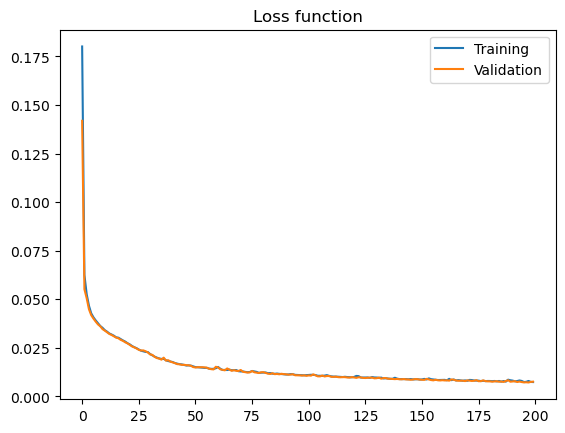

In [197]:
plt.plot(avg_train_loss, label='Training')
plt.plot(avg_val_loss, label='Validation')
plt.title('Loss function')
plt.legend()
plt.show()

3/3 [==============================] - 0s 2ms/step
Train Root Mean Squared Error: 0.08500353775554748
Train Mean Absolute Error: 0.06597817014109028
Train R2: 0.8375161758922514


Test Root Mean Squared Error: 0.02461140963421539
Test Mean Absolute Error: 0.12912679838400865
Test R2: 0.4189091870693191




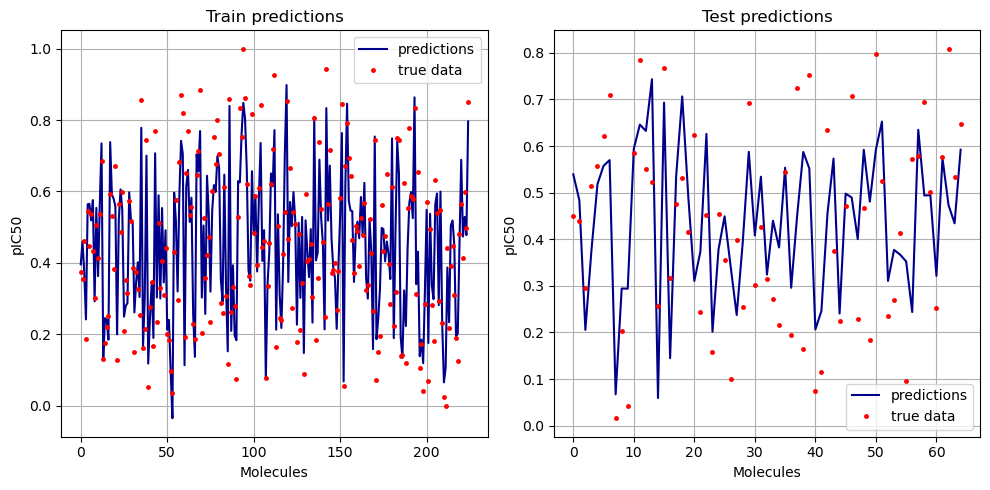

In [198]:
pred_Y_train_dnn = model_CNN.predict(train_X)
pred_Y_val_dnn = model_CNN.predict(val_X)
evaluate(train_Y, pred_Y_train_dnn, val_Y, pred_Y_val_dnn)
visualizeTrainTest(train_Y, pred_Y_train_dnn, val_Y, pred_Y_val_dnn)